# Modeling

### Cleanance

In [1]:
import pyodbc
import pandas as pd
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
cursor = connStr.cursor()

qry = "SELECT * FROM [Prices].[dbo].[prices] where cast([Country] as nvarchar) = cast('ES' as nvarchar)"
df_prices = pd.read_sql(qry, connStr)

df_prices.shape

(447, 11)

In [2]:
# Dates in campaign time format
# df_prices['Campaign_Date'] = df_prices['Year_campaign'].astype(str) + df_prices['Week_num_campaign'].astype(str)
# https://stackoverflow.com/questions/17087314/get-date-from-week-number
# df_prices['Campaign_Date'] = df_prices['Campaign_Date'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y%W-%w"))

# Dates natural date format
blue = df_prices[(df_prices.Product=='BLUEBERRIES') & (df_prices.Year_campaign>2015) & (df_prices.Week_num_campaign<50)][['Date_ref', 'Price']]
blue.set_index('Date_ref',inplace=True)
blue.sort_index(inplace=True)
blue.index = blue.index.astype('datetime64[ns]') 
blue_weeks = blue.resample('W').mean().asfreq('W')
rows_null = blue_weeks.isnull()
idx_null = rows_null[rows_null.any(axis=1)].index
blue_full = blue_weeks.interpolate()


In [3]:
listIndex = list(zip(blue_full.index, range(0,len(blue_full))))     # save all indexes in tuples list (index, idPosition)
listNull = idx_null     # save all null indexes

dfIndex = pd.DataFrame(listIndex)
dfNull = pd.DataFrame(listNull)
dfIndex.columns = ['Date_ref','ID']
dfNullID = dfIndex.merge(dfNull, how='inner', on='Date_ref')    # this dataframe contains the null indexes with their original index id

## First model!!
## https://www.youtube.com/watch?v=WjeGUs6mzXg

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA

In [14]:

model = SARIMAX(blue_full, order = (3,1,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  234
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 -91.388
Date:                Sat, 11 Jul 2020   AIC                            194.776
Time:                        15:44:14   BIC                            215.482
Sample:                    01-10-2016   HQIC                           203.125
                         - 06-28-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5639      0.068     -8.311      0.000      -0.697      -0.431
ar.L2         -0.3217      0.073     -4.422      0.000      -0.464      -0.179
ar.L3          0.4244      0.048      8.769      0.000       0.330       0.519
ma.L1          1.0200      0.059     17.173      0.000       0.904       1.136
ma.L2          0.9412      0.057     16.435      0.000       0.829       1.053
sigma2         0.1276      0.006     20.896      0.000       0.116       0.140
===================================================================================
Ljung-Box (Q):                       22.76   Jarque-Bera (JB):               502.85
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.95
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

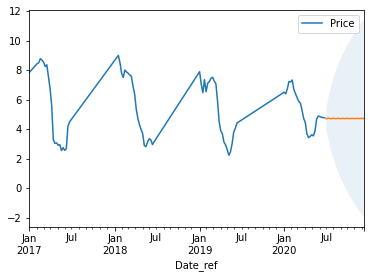

In [16]:
blue_full.truncate(before='2017').plot()
prediction = model.get_forecast(steps=24)
prediction.predicted_mean.plot()
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
plt.fill_between(lower.index,lower,upper, alpha=0.1)
plt.show()

### MSE, RMSE, MAE, MAPE

In [7]:

# Use against predictions

predictions_clean = model.fittedvalues[~model.fittedvalues.index.isin(idx_null)]
blue_clean = blue_full[~blue_full.index.isin(idx_null)]
# https://stackoverflow.com/questions/27965295/dropping-rows-from-dataframe-based-on-a-not-in-condition?rq=1

mse = mean_squared_error(predictions_clean, blue_clean.Price)
rmse = np.sqrt(mean_squared_error(predictions_clean, blue_clean.Price))
mae = mean_absolute_error(predictions_clean, blue_clean.Price)
mape = np.mean(np.abs(predictions_clean-blue_clean.Price)/blue_clean.Price)

print(f'MSE {mse}, RMSE {rmse},*** \033[1mMAE {mae} ***\033[1m, MAPE {mape}')

MSE 0.9892219367241887, RMSE 0.9945963687467337,*** MAE 0.429270655163812 ***, MAPE 0.08169478985758574


In [ ]:
# AIC and BIC metrics

warnings.simplefilter('ignore')
#https://stackoverflow.com/questions/34444607/how-to-ignore-statsmodels-maximum-likelihood-convergence-warning
best_aic = 999999
for p in range(3):
    for q in range(2):
        for d in range(2):
            try:
                model = SARIMAX(blue, order = (p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    print(p, d, q, model.aic, model.bic)
            except:
                pass

In [5]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X_clean = pd.DataFrame(X)[~pd.DataFrame(X).index.isin(dfNullID['ID'])].values # Pick only campaign weeks for measure the prediction error
	train_size = int(len(X_clean) * 0.66)
	train, test = X_clean[0:train_size], X_clean[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model_fit = SARIMAX(history, order=arima_order).fit()
		#model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_absolute_error(test, predictions) #MAE is the metric selected as price fluctuation could be up or down
	
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mae = evaluate_arima_model(dataset, order)
					if mae < best_score:
						best_score, best_cfg = mae, order
					print('ARIMA%s MAE=%.3f' % (order,mae))
				except:
					continue
	print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))

In [98]:
# evaluate parameters
p_values = [3]
d_values = [1]
q_values = [2]
warnings.filterwarnings("ignore")

evaluate_models(blue_full.values, p_values, d_values, q_values)

ARIMA(3, 1, 2) MAE=0.364
Best ARIMA(3, 1, 2) MAE=0.364


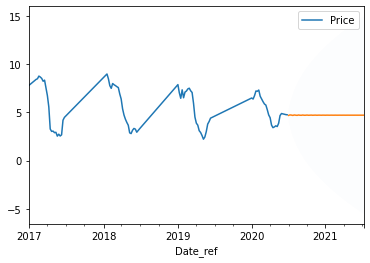

In [106]:
model = SARIMAX(blue_full, order = (3, 1, 2)).fit() 
prediction = model.get_forecast(steps = 54)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue_full.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.01)
plt.show()

### Our data is weekly based and the exploratory analysis has shown us that there is a clear seasonality. 
### So let's set up seasonal_order parameter to see if we improve the estimation.

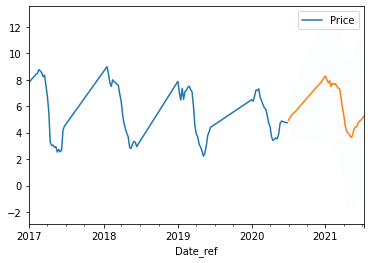

In [9]:
model = SARIMAX(blue_full, order = (3, 1, 2), seasonal_order=(1, 1, 1, 52)).fit() #,seasonal_order=(1,1,2,12)
prediction = model.get_forecast(steps = 52)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue_full.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.01)
plt.show()

### Now let's try to find the best order parameter setting to improve our prediction 

In [6]:

# evaluate parameters
p_values = range(0, 8)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(blue_full.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MAE=4.832
ARIMA(0, 0, 1) MAE=2.417
ARIMA(0, 0, 2) MAE=1.571
ARIMA(0, 1, 0) MAE=0.398
ARIMA(0, 1, 1) MAE=0.379
ARIMA(0, 1, 2) MAE=0.356
ARIMA(0, 2, 0) MAE=0.394
ARIMA(0, 2, 1) MAE=0.403
ARIMA(0, 2, 2) MAE=0.370
ARIMA(1, 0, 0) MAE=0.383
ARIMA(1, 0, 1) MAE=0.359
ARIMA(1, 0, 2) MAE=0.338
ARIMA(1, 1, 0) MAE=0.372
ARIMA(1, 1, 1) MAE=0.354
ARIMA(1, 1, 2) MAE=0.351
ARIMA(1, 2, 0) MAE=0.406
ARIMA(1, 2, 1) MAE=0.362
ARIMA(1, 2, 2) MAE=0.390
ARIMA(2, 0, 0) MAE=0.350
ARIMA(2, 0, 1) MAE=0.332
ARIMA(2, 0, 2) MAE=0.331
ARIMA(2, 1, 0) MAE=0.351
ARIMA(2, 1, 1) MAE=0.351
ARIMA(2, 1, 2) MAE=0.353
ARIMA(2, 2, 0) MAE=0.386
ARIMA(2, 2, 1) MAE=0.343
ARIMA(2, 2, 2) MAE=0.350
ARIMA(3, 0, 0) MAE=0.331
ARIMA(3, 0, 1) MAE=0.330
ARIMA(3, 0, 2) MAE=0.333
ARIMA(3, 1, 0) MAE=0.350
ARIMA(3, 1, 1) MAE=0.346
ARIMA(3, 1, 2) MAE=0.364
ARIMA(3, 2, 0) MAE=0.395
ARIMA(3, 2, 1) MAE=0.339
ARIMA(3, 2, 2) MAE=0.345
ARIMA(4, 0, 0) MAE=0.329
ARIMA(4, 0, 1) MAE=0.326
ARIMA(4, 0, 2) MAE=0.338
ARIMA(4, 1, 0) MAE=0.349


In [7]:
# evaluate parameters
p_values = [7]
d_values = [2]
q_values = [2]
warnings.filterwarnings("ignore")

evaluate_models(blue_full.values, p_values, d_values, q_values)

ARIMA(7, 2, 2) MAE=0.301
Best ARIMA(7, 2, 2) MAE=0.301


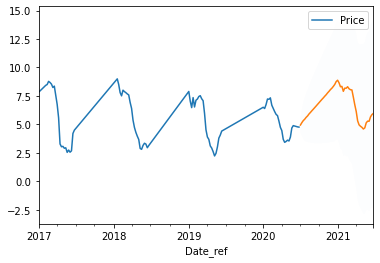

In [8]:
model = SARIMAX(blue_full, order = (7, 2, 2), seasonal_order=(1, 1, 1, 52)).fit() #,seasonal_order=(1,1,2,12)
prediction = model.get_forecast(steps = 52)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue_full.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.3)
plt.show()

In [37]:
pd.DataFrame(model.fittedvalues[~model.fittedvalues.index.isin(idx_null)]).rename(columns = {0 : 'Price_fitted'}).join(blue_full[~blue_full.index.isin(idx_null)]).to_excel('Sarimax.xlsx')